In [101]:
import re
import csv
import math
import nltk
import json
import numpy as np
import pandas as pd
from Index import Index
from matplotlib import pyplot as plt

# Predictions

In [102]:
index = Index(('DS\\index.json', 'DS\\inverted.json', 'DS\\queries.json', 'DS\\ground_truth.csv', 'DS\\raw_queries.json', 'DS\\raw_docs.json'), preprocessed=True)

## Vector

In [103]:
predicted_scalar = index.vector_search(max_docs=1460, metric='scalar') 
index.PR([[i[0] for i in j] for j in list(predicted_scalar.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [01:06<00:00,  1.14it/s]


(0.028037130497476574, 0.9994801089185152)

In [104]:
with open('Predictions\\pred_scalar.json', 'w', encoding='utf-8') as f: 
    json.dump({str(k): v for k, v in predicted_scalar.items()}, f, ensure_ascii=False, indent=4) 

In [105]:
predicted_cos = index.vector_search(max_docs=1460, metric='cosine')
index.PR([[i[0] for i in j] for j in list(predicted_cos.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [02:03<00:00,  1.63s/it]


(0.028037130497476574, 0.9994801089185152)

In [106]:
with open('Predictions\\pred_cos.json', 'w', encoding='utf-8') as f: 
    json.dump({str(k): v for k, v in predicted_cos.items()}, f, ensure_ascii=False, indent=4) 

In [107]:
predicted_jacc = index.vector_search(max_docs=1460, metric='jaccard') 
index.PR([[i[0] for i in j] for j in list(predicted_jacc.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [03:05<00:00,  2.45s/it]


(0.028037130497476574, 0.9994801089185152)

In [108]:
with open('Predictions\\pred_jacc.json', 'w', encoding='utf-8') as f:
    json.dump({str(k): v for k, v in predicted_jacc.items()}, f, ensure_ascii=False, indent=4) 

## BM25

In [109]:
predicted_bm25 = index.BM25() 
index.PR([[i[0] for i in j[:25]] for j in predicted_bm25], index.relevent_docs)[2:] 

100%|██████████| 76/76 [00:09<00:00,  7.90it/s]


(0.052105263157894745, 0.03607191392734016)

In [110]:
predicted_bm25 = [[[str(i), l] for i, l in j] for j in predicted_bm25]
predicted_bm25 = {str(i): j for i, j in enumerate(predicted_bm25)}

In [111]:
with open('Predictions\\pred_bm25.json', 'w', encoding='utf-8') as f:
    json.dump(predicted_bm25, f, ensure_ascii=False, indent=4)

## Bool

In [112]:
docs = index.parse_boolean_query('structures and (structural or formulas) and (not drawing and compounds) or chemical') 

# Evaluation

## P5 and P10

In [113]:
preds = [predicted_scalar, predicted_cos, predicted_jacc, predicted_bm25]

In [114]:
def precision(i, pred, relevent):
    pred = [[i[0] for i in j[:i]] for j in list(pred.values())]
    return index.PR(pred, index.relevent_docs)[2]

In [115]:
def recall(i, pred, relevent):
    pred = [[i[0] for i in j[:i]] for j in list(pred.values())]
    return index.PR(pred, index.relevent_docs)[3]

In [116]:
for pred in preds:
    print(precision(5, pred, index.relevent_docs)) 

0.05000000000000001
0.06315789473684211
0.08157894736842107
0.04736842105263159


In [117]:
for pred in preds:
    print(precision(10, pred, index.relevent_docs))

0.05394736842105264
0.06052631578947368
0.06842105263157895
0.05526315789473685


## ROC

In [118]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def ROC(pred, relevent, step=10):
    PR = []
    for thresh in range(1, step):
        PR.append(index.PR([[i[0] for i in j[:thresh]] for j in list(pred.values())], relevent)[2:])
    PR = np.array(PR)
    roc = []
    recalls = list(frange(0, 1.01, 1/(10*len(PR))))
    for r, pr in zip(recalls, PR):
        filtered = [i[0] for i in PR if i[1] >= r]
        p = max(filtered) if filtered else 0
        roc.append((p, r)) 
    return roc

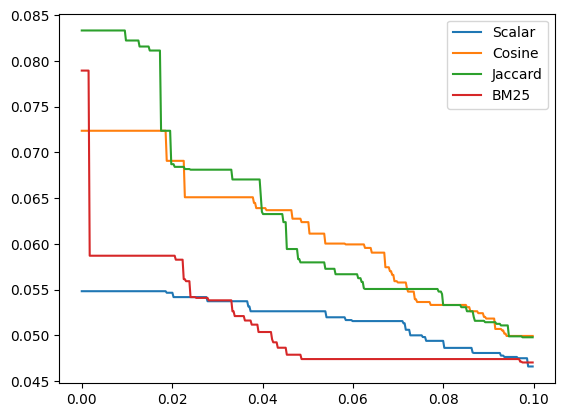

In [119]:
rocs = [] 
models = ['Scalar', 'Cosine', 'Jaccard', 'BM25']
for pred in preds:
    rocs.append(np.array(ROC(pred, index.relevent_docs, 400))) 

for roc, model in zip(rocs, models):
    plt.plot(roc[:, 1], roc[:, 0], label=model)
plt.legend()
plt.show() 

## Summary

In [120]:
eval = []
names = ['Scalar', 'Cosine', 'Jaccard', 'BM25']
for pred, name in zip(preds, names):
    p5 = round(precision(5, pred, index.relevent_docs), 3)
    p10 = round(precision(10, pred, index.relevent_docs), 3)
    p25 = round(precision(25, pred, index.relevent_docs), 3)
    r5 = round(recall(5, pred, index.relevent_docs), 3)
    r10 = round(recall(10, pred, index.relevent_docs), 3)
    r25 = round(recall(25, pred, index.relevent_docs), 3)
    eval.append([name, p5, r5, round((2*p5*r5)/(p5+r5), 3), p10, r10, round((2*p10*r10)/(p10+r10), 3), p25, r25, round((2*p25*r25)/(p25+r25), 3)])

eval = pd.DataFrame(eval)
eval.columns = ['Model', 'P5', 'R5', 'F5', 'P10', 'R10', 'F10', 'P25', 'R25', 'F25']
eval.to_csv('Eval//Eval.csv') 

In [121]:
eval = pd.read_csv('Eval//Eval.csv')
eval.drop([eval.columns[0]], axis=1)

,Model,P5,R5,F5,P10,R10,F10,P25,R25,F25
0,Scalar,0.050,0.007,0.012,0.054,0.016,0.025,0.053,0.037,0.044
1,Cosine,0.063,0.012,0.020,0.061,0.024,0.034,0.064,0.047,0.054
2,Jaccard,0.082,0.015,0.025,0.068,0.023,0.034,0.063,0.043,0.051
3,BM25,0.047,0.005,0.009,0.055,0.016,0.025,0.052,0.036,0.043


In [122]:
for name, roc in zip(names, rocs):
    np.save('Eval//'+name, roc)